In [77]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

In [78]:
# First let's load the data and take a look at the first few rows.


# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/timshilstone/marketing_analysis/main/online.csv"
download = requests.get(url).content


# Reading the downloaded content and turning it into a pandas dataframe

online = pd.read_csv(io.StringIO(download.decode('utf-8')))


# Printing out the first 5 rows of the dataframe

online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [79]:
# Let's check for anay null values. Everything seems to be good.
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   70864 non-null  int64  
 1   InvoiceNo    70864 non-null  int64  
 2   StockCode    70864 non-null  object 
 3   Description  70864 non-null  object 
 4   Quantity     70864 non-null  int64  
 5   InvoiceDate  70864 non-null  object 
 6   UnitPrice    70864 non-null  float64
 7   CustomerID   70864 non-null  int64  
 8   Country      70864 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 4.9+ MB


In [80]:
# We'll need to transform the InvoiceDate column from a string to a datetime for analysis.

In [81]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

### Define Time-based Cohorts

In [82]:
# We're going to create monthly buckets of customers based on the month of their first purchase. To start we need to 
# pull the year and month from the InvoiceDate column.

In [83]:
def get_month(x):
    return dt.datetime(x.year,x.month,1)

In [84]:
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

In [85]:
# Second we want to group all transactions made by each unique CustomerID and select the month the
# oldest transaction was made in and save this to CohortMonth. This could also be thought of as the month the user 
# first made a purchase with the company.

In [86]:
grouping = online.groupby('CustomerID')['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')

In [87]:
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [88]:
# Next we'd like to calculate the number of months it has been since the user made their first purchase. We create
# a function to get the year, month, and day from a column in the dataset.

In [89]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [90]:
# We pass InvoiceMonth and CohortMonth to the function saving the results to the corresponding variables.

In [91]:
invoice_year, invoice_month = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month  = get_date_int(online, 'CohortMonth')

In [92]:
# And we calculate the difference in the number of months between the first purchase and the rows transaction month.

In [93]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

online['CohortIndexMonth'] = years_diff * 12 + months_diff + 1
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndexMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,4


In [94]:
# Next we'd like to select the number of useres in each cohort. First we group the data by Cohortmonth and 
# CohortIndexMonth. Then we select the number of unique CustomerID's in each group and display them in a Pivot Table.

In [95]:
grouping = online.groupby(['CohortMonth','CohortIndexMonth'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                 columns = 'CohortIndexMonth',
                                 values='CustomerID')

In [96]:
cohort_counts

CohortIndexMonth,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# The first column show's the number of users in each group. Let's save this to cohort_sizes.

In [98]:
cohort_sizes = cohort_counts.iloc[:,0]

In [99]:
# To calculate the retention of each cohort month to month we divide the cohort count by the initial cohort size.

In [100]:
retention = cohort_counts.divide(cohort_sizes,axis=0)

In [101]:
# Finally we plot this data to a heatmap for analysis. 
# As you can see 49% of users that made their first purchase in December of 2010 made a purchase 
# 11 months from signing up.

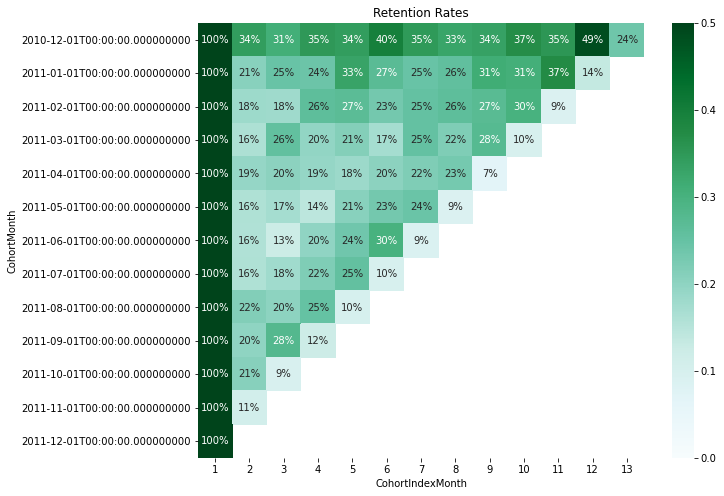

In [102]:
plt.figure(figsize=(10,8))
plt.title('Retention Rates')
sns.heatmap(data = retention,
           annot = True,
           fmt = '.0%',
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')
plt.show()

In [103]:
# Next let's look at the average spend by cohort. First, like with retention, we group by CohortMonth and CohortIndex.
# Then we select the average UnitPrice for each instance.

In [104]:
grouping = online.groupby(['CohortMonth', 'CohortIndexMonth'])
cohort_data = grouping['UnitPrice'].mean().reset_index()
average_price = cohort_data.pivot(index='CohortMonth',
                                 columns='CohortIndexMonth',
                                 values='UnitPrice')

In [105]:
# Finally we plot this data to a heatmap for analysis. 
# As you can see the average trasaction price the users in December 2010 cohort made was 6.9. 

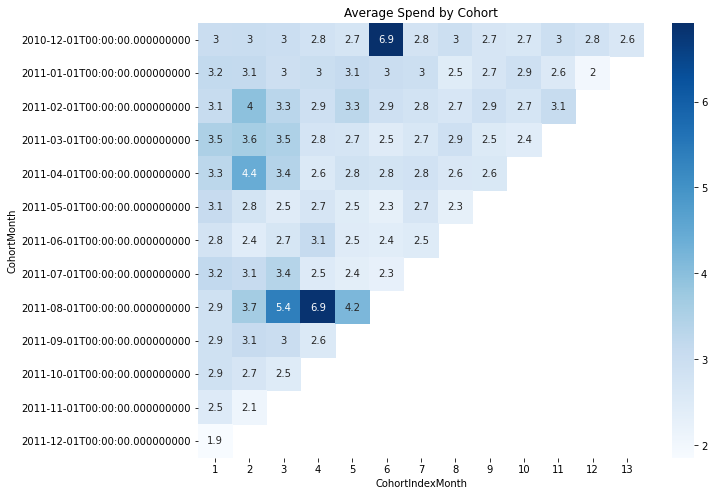

In [106]:
plt.figure(figsize=(10,8))
plt.title('Average Spend by Cohort')
sns.heatmap(data=average_price,
           annot=True,
           cmap='Blues')
plt.show()